# **Model trained with UnBalanced Data and Rating Scale (1-6)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Load data
# If using Kaggle, ensure the Kaggle API is configured and download the dataset
# If using files, replace the path variables with file paths
def load_data():
    users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
    books = pd.read_csv('BX_Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
    ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')

    return users, books, ratings

users, books, ratings = load_data()

# Preprocessing Users Table
users['Age'].fillna(users['Age'].median(), inplace=True)
users['Location'] = users['Location'].str.split(',').str[-1].str.strip() # Simplify to country level

# Preprocessing Books Table
books['Book-Title'].fillna('Unknown', inplace=True)
books['Book-Author'].fillna('Unknown', inplace=True)
books['Year-Of-Publication'].fillna(books['Year-Of-Publication'].median(), inplace=True)

# Filter ratings and merge
ratings = ratings[ratings['Book-Rating'] > 0] # Remove implicit feedback
ratings = ratings.merge(users, on='User-ID').merge(books, on='ISBN')

# Indexing Book ID starting from 1
ratings['Book-ID'] = pd.factorize(ratings['ISBN'])[0] + 1

# Label encoding categorical variables
user_encoder = LabelEncoder()
ratings['User-ID'] = user_encoder.fit_transform(ratings['User-ID'])

location_encoder = LabelEncoder()
ratings['Location'] = location_encoder.fit_transform(ratings['Location'])

book_title_encoder = LabelEncoder()
ratings['Book-Title'] = book_title_encoder.fit_transform(ratings['Book-Title'])

book_author_encoder = LabelEncoder()
ratings['Book-Author'] = book_author_encoder.fit_transform(ratings['Book-Author'])

# Scale numerical features
scaler = MinMaxScaler()
ratings['Age'] = scaler.fit_transform(ratings[['Age']])
ratings['Year-Of-Publication'] = scaler.fit_transform(ratings[['Year-Of-Publication']])

# Label ratings
ratings['Label'] = (ratings['Book-Rating'] > 6).astype(int)


# Split features and labels
X = ratings[['User-ID', 'Location', 'Age', 'Book-ID', 'Book-Title', 'Book-Author', 'Year-Of-Publication']]
y = ratings['Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network
def build_model(num_users, num_locations, num_books, num_titles, num_authors, embedding_dim=50):
    # Inputs
    user_input = Input(shape=(1,), name='User-ID')
    location_input = Input(shape=(1,), name='Location')
    age_input = Input(shape=(1,), name='Age')
    book_input = Input(shape=(1,), name='Book-ID')
    title_input = Input(shape=(1,), name='Book-Title')
    author_input = Input(shape=(1,), name='Book-Author')
    year_input = Input(shape=(1,), name='Year-Of-Publication')

    # Embedding layers
    user_embedding = Embedding(num_users, embedding_dim, input_length=1)(user_input)
    location_embedding = Embedding(num_locations, embedding_dim, input_length=1)(location_input)
    book_embedding = Embedding(num_books, embedding_dim, input_length=1)(book_input)
    title_embedding = Embedding(num_titles, embedding_dim, input_length=1)(title_input)
    author_embedding = Embedding(num_authors, embedding_dim, input_length=1)(author_input)

    # Flatten embeddings
    user_flat = Flatten()(user_embedding)
    location_flat = Flatten()(location_embedding)
    book_flat = Flatten()(book_embedding)
    title_flat = Flatten()(title_embedding)
    author_flat = Flatten()(author_embedding)

    # Combine all features
    features = Concatenate()([user_flat, location_flat, age_input, book_flat, title_flat, author_flat, year_input])

    # Dense layers
    dense = Dense(256, activation='relu')(features)
    dense = Dropout(0.5)(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)

    # Model
    model = Model(inputs=[user_input, location_input, age_input, book_input, title_input, author_input, year_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
num_users = ratings['User-ID'].nunique()+1
num_locations = ratings['Location'].nunique()+1
num_books = ratings['Book-ID'].nunique()+1
num_titles = ratings['Book-Title'].nunique()+1
num_authors = ratings['Book-Author'].nunique()+1

model = build_model(num_users, num_locations, num_books, num_titles, num_authors)


<ipython-input-1-4bd18483b0a2>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['Age'].fillna(users['Age'].median(), inplace=True)
<ipython-input-1-4bd18483b0a2>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

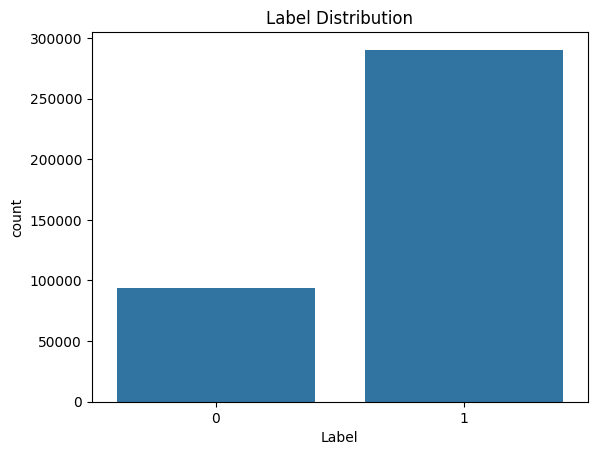

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Label', data=ratings)
plt.title('Label Distribution')
plt.show()


In [ ]:
# Ensure inputs are NumPy arrays with correct data types
X_train_prepared = [
    np.array(X_train['User-ID'], dtype=np.int32),
    np.array(X_train['Location'], dtype=np.int32),
    np.array(X_train['Age'], dtype=np.float32),
    np.array(X_train['Book-ID'], dtype=np.int32),
    np.array(X_train['Book-Title'], dtype=np.int32),
    np.array(X_train['Book-Author'], dtype=np.int32),
    np.array(X_train['Year-Of-Publication'], dtype=np.float32),
]

X_test_prepared = [
    np.array(X_test['User-ID'], dtype=np.int32),
    np.array(X_test['Location'], dtype=np.int32),
    np.array(X_test['Age'], dtype=np.float32),
    np.array(X_test['Book-ID'], dtype=np.int32),
    np.array(X_test['Book-Title'], dtype=np.int32),
    np.array(X_test['Book-Author'], dtype=np.int32),
    np.array(X_test['Year-Of-Publication'], dtype=np.float32),
]

# Labels as NumPy arrays
y_train_prepared = np.array(y_train, dtype=np.float32)
y_test_prepared = np.array(y_test, dtype=np.float32)

# Train the model
history = model.fit(
    X_train_prepared,
    y_train_prepared,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_prepared, y_test_prepared)

print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 335s 173ms/step - accuracy: 0.7625 - loss: 0.5284 - val_accuracy: 0.7867 - val_loss: 0.4739
Epoch 2/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 391s 178ms/step - accuracy: 0.8562 - loss: 0.3463 - val_accuracy: 0.7554 - val_loss: 0.5437
Epoch 3/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 386s 181ms/step - accuracy: 0.9021 - loss: 0.2400 - val_accuracy: 0.7175 - val_loss: 0.6605
Epoch 4/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 360s 169ms/step - accuracy: 0.9269 - loss: 0.1719 - val_accuracy: 0.7199 - val_loss: 0.8061
Epoch 5/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 381s 169ms/step - accuracy: 0.9437 - loss: 0.1304 - val_accuracy: 0.7138 - val_loss: 0.9907
Epoch 6/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 324s 169ms/step - accuracy: 0.9551 - loss: 0.1033 - val_accuracy: 0.6932 - val_loss: 1.2213
Epoch 7/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 324s 169ms/step - accuracy: 0.9660 - loss: 0.0804 - val_accuracy: 0.6903 - val_loss: 1.3209
Epoch 8/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 383s 170ms/step - ac

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import numpy as np

# Make predictions
y_pred_probs = model.predict(X_test_prepared)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert to binary (assuming binary classification)

# Precision
precision = precision_score(y_test_prepared, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test_prepared, y_pred, average='binary')
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_test_prepared, y_pred, average='binary')
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_prepared, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Mean Average Precision (MAP)
average_precision = average_precision_score(y_test_prepared, y_pred_probs)
print(f"Mean Average Precision (MAP): {average_precision:.2f}")


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Precision: 0.82
Recall: 0.74
F1 Score: 0.78
Confusion Matrix:
[[ 9414  9440]
 [15076 42841]]
Mean Average Precision (MAP): 0.85
